In [1]:
import numpy as np
from scipy.integrate import odeint, ode
import matplotlib.pyplot as plt
from dataclasses import dataclass
from typing import Tuple

In [2]:
class Flow:
    def __init__(self, lines, required_parameters):
        self.equation = lines[0].replace('\n', '').replace("$0", lines[1][:-1]).replace("$1", lines[2][:-1])#[:-1]
        self.source = parse(read(lines[1])[0])#[:-1]
        self.sink = parse(read(lines[2])[0])#[:-1]
        self.compiled_equation = compile(parse(read(self.equation)[0]), required_parameters)

    def __repr__(self):
        return f'Flow: equation{self.equation}'

class Function:
    def __init__(self, operator, operands) -> None:
        self.operator = operator
        self.operands = operands

    def __repr__(self):
        if isinstance(self.operator, WordOrSymbol) and self.operator.value == 'parameter':
            return f'parameter: {self.operands})'
        else:
            return f'Function: ({self.operator} {" ".join([str(o) for o in self.operands])})'

class Compartment:
    def __init__(self, labels) -> None:
        self.labels = labels

    def __repr__(self):
        return 'Compartment' + str(self.labels)

class WordOrSymbol:
    def __init__(self, value: str) -> None:
        self.value = value

    def __repr__(self):
        return self.value

class ReadResult:
    def __init__(self, string_value: str, object_type: type) -> None:
        self.string_value = string_value
        self.object_type = object_type

def read(string: str, i: int = 0):
    string = string.replace('\n', ' ').replace('\t', ' ')
    beg = string[i]
    while string[i] == ' ':
        i += 1
    if beg == '(':
        return read_fn(string, i)
    elif beg == '[':
        return read_compartment(string, i)
    else:
        return read_word_or_symbol(string, i)

def read_fn(string: str, i: int):
    start = i
    depth = 0
    while True:
        if string[i] == '(':
            depth += 1
        elif string[i] == ')':
            depth -= 1
        i += 1
        if depth == 0:
            break
    return ReadResult(string[start:i], Function), i + 1

def read_compartment(string: str, i: int):
    start = i
    while string[i] != ']':
        i += 1
    # include the closing bracket
    i += 1
    return ReadResult(string[start:i], Compartment), i + 1

def read_word_or_symbol(string: str, i: int):
    start = i
    while i < len(string) and string[i] != ' ' and string[i] != '[' and string[i] != ')' and string[i] != '(':
        i += 1
    return ReadResult(string[start:i], WordOrSymbol), i + 1

def parse(read_result: ReadResult):
    parser = {
        Function: parse_fn,
        Compartment: parse_compartment,
        WordOrSymbol: parse_word_or_symbol
    }
    return parser[read_result.object_type](read_result.string_value)

def parse_fn(string: str):
    string = string[1:-1] # take `...` from `(...)`
    terms = []
    i = 0
    while i < len(string):
        if string[i] == ' ':
            i += 1
            continue
        r, i = read(string, i)
        terms += [parse(r)]
    return Function(terms[0], terms[1:])

def parse_compartment(string: str):
    if string[-1] != ']':
       raise 1
    string = string[1:-1] # take `...` from `[...]`
    return Compartment([s.strip() for s in string.split(',')])

def parse_word_or_symbol(string: str):
    return WordOrSymbol(string)

def compile(parse_result, required_parameters):
    compiler = {
        Function: compile_equation,
        Compartment: compile_compartment,
        WordOrSymbol: compile_word_or_symbol
    }
    return compiler[type(parse_result)](parse_result, required_parameters)

def compile_compartment(compartment: Compartment, required_parameters):
    s = set(compartment.labels)
    indices = [i for i, c in enumerate(compartments) if set(c).issuperset(s)]
    if len(indices) == 1:
        return lambda state: state[indices[0]]
    else:
        return lambda state: [state[i] for i in indices]

def compile_word_or_symbol(word_or_symbol: WordOrSymbol, required_parameters):
    return lambda state: word_or_symbol

def compile_equation(equation: Function, required_parameters):
    if isinstance(equation.operator, WordOrSymbol):
        fn = equation.operator.value
        # parameters are a special function and could have their own
        # element in the grammar (such as the use of brackets) to denote them
        # but for now they are denoted using `(parameter ...)` like other functions
        if fn == 'parameter':
            prepare_parameter(equation.operands, required_parameters)
            parameters = get_parameters(equation.operands, required_parameters)
            return lambda state: [parameter.evaluate() for parameter in parameters]
        else:
            compiled_operands = [compile(operand, required_parameters) for operand in equation.operands]
            if fn == '*':
                return lambda state: product([operand(state) for operand in compiled_operands])
            elif fn == 'sumproduct':
                return lambda state: sumproduct([operand(state) for operand in compiled_operands])
            else:
                raise Exception(f"Unknown function `{fn}`")
    else:
        raise Exception(f"Expected operator of type {WordOrSymbol}, received {type(equation.operator)}")

def product(terms):
  p = 1
  for t in terms:
    if isinstance(t, list):
       p *= sum(t)
    else:
       p *= t
  return p

def sumproduct(values):
    expected_len = len(values[0])
    for v in values:
      if len(v) != expected_len:
        raise Exception('could not broadcast matrices or vectors')
    return sum([product([value[i] for value in values]) for i in range(len(values[0]))])

def parse_compartments(line):
  return [parse_compartment(c) for c in line.replace('[[', '[').replace(']]', ']').replace('\n', '').split('], ')]

class Parameter:
    def __init__(self, name, value) -> None:
        self.name = name
        self.value = value

    def evaluate(self):
        if self.value is None:
            raise Exception(f"None valued parameter '{self.name}'")
        else:
            return self.value

def prepare_parameter(operands, required_parameters):
    is_partial_spec = False
    for i, operand in enumerate(operands):
        if isinstance(operand, Compartment):
            is_full_compartment_specification = operand in compartments
            if not is_partial_spec:
                is_partial_spec = True
            if not is_full_compartment_specification:
                s = set(operand.labels)
                subsets_of_partial_specialization = [c for c in compartments if set(c).issuperset(s)]
                before, after = operands[:i], operands [i+1:]
                for c in subsets_of_partial_specialization:
                    prepare_parameter(before + [c] + after, required_parameters)
    if not is_partial_spec:
        key = str(parse_compartment(str(operands)).labels)
        if key not in required_parameters:
            required_parameters[key] = Parameter(operands, None)

def get_parameters(operands, required_parameters):
    is_partial_spec = False
    for i, operand in enumerate(operands):
        if isinstance(operand, Compartment):
            is_full_compartment_specification = operand in compartments
            if not is_partial_spec:
                is_partial_spec = True
            if not is_full_compartment_specification:
                s = set(operand.labels)
                subsets_of_partial_specialization = [c for c in compartments if set(c).issuperset(s)]
                before, after = operands[:i], operands [i+1:]
                res = []
                for c in subsets_of_partial_specialization:
                    params = get_parameters(before + [c] + after, required_parameters)
                    if isinstance(params, list):
                        res.extend(params)
                    else:
                        res.extend([params])
                return res
    if not is_partial_spec:
        return [required_parameters[str(parse_compartment(str(operands)).labels)]]

def evalDelta(flows, state):
    res = 0
    for flow in flows:
        res += flow.compiled_equation(state)
    return res

def derivativeForCompartmentIndex(i):
    return lambda state: evalDelta(flowsbycompartment[i][0], state) - evalDelta(flowsbycompartment[i][1], state)

def test_required_parameters(required_parameters):
    return [name for name, parameter in required_parameters.items() if parameter.value is None]

def model_derivative(state, t):
    state = [x if x > 0 else 0 for x in state]
    d = [derivatives[i](state) for i in range(len(state))]
    return d

In [3]:
filename = 'HIV-TB Coinfection'

compartments = [parse_compartment(line[:-1]).labels for line in open(f'{filename}.compartments.txt').readlines()]
number_of_lines_per_flow_in_file = 4
flows = open(f'{filename}.equations.txt').readlines()
flows = [flows[i * number_of_lines_per_flow_in_file:(i + 1) * number_of_lines_per_flow_in_file] for i in range(int(len(flows) / number_of_lines_per_flow_in_file))]
provided_parameters = {str(parse_compartment(k.strip()).labels): Parameter(k, float(v)) for k, v in [s.split('=') for s in open(f'{filename}.parameters.txt').readlines()]}
flows = [Flow(lines, provided_parameters) for lines in flows]

# each compartment has an in and an out list
flowsbycompartment = [[[], []] for _ in compartments]
for flow in flows:
  source = compartments.index(flow.source.labels)
  sink = compartments.index(flow.sink.labels)
  _in,_out = 0,1
  flowsbycompartment[source][_out] += [flow]
  flowsbycompartment[sink  ][_in ] += [flow]

print(f'model size = {len(compartments)}')
print(f'model equations = {len(flows)}')


testkey = str(parse_compartment("[contact-mixing, Exposure-HIV, ['Age', 'Alive', 'Child', 'HIV', 'HIV-TB Coinfection', 'I-HIV', 'M', 'Mortality', 'S-TB', 'Sex', 'Tuberculosis']]").labels)
missing_parameters = test_required_parameters(provided_parameters)

if len(missing_parameters) > 0:
    print("Missing Parameters:")
    for parameter in missing_parameters:
        print(parameter)
    print("Exiting...")
else:
    derivatives = [derivativeForCompartmentIndex(i) for i in range(len(compartments))]

    initial_conditions = {str(c) : 1 for c in compartments}

    print(model_derivative([initial_conditions[str(c)] for c in compartments], 0))

model size = 256
model equations = 576
[-129.0, -127.0, -2.0, 0.0, -65.0, -63.0, -64.0, -62.0, -129.0, -127.0, -2.0, 0.0, -65.0, -63.0, -64.0, -62.0, -129.0, -127.0, -2.0, 0.0, -65.0, -63.0, -64.0, -62.0, -129.0, -127.0, -2.0, 0.0, -65.0, -63.0, -64.0, -62.0, -129.0, -127.0, -2.0, 0.0, -65.0, -63.0, -64.0, -62.0, -129.0, -127.0, -2.0, 0.0, -65.0, -63.0, -64.0, -62.0, -129.0, -127.0, -2.0, 0.0, -65.0, -63.0, -64.0, -62.0, -129.0, -127.0, -2.0, 0.0, -65.0, -63.0, -64.0, -62.0, -2.0, 0.0, 125.0, 127.0, 62.0, 64.0, 63.0, 65.0, -2.0, 0.0, 125.0, 127.0, 62.0, 64.0, 63.0, 65.0, -2.0, 0.0, 125.0, 127.0, 62.0, 64.0, 63.0, 65.0, -2.0, 0.0, 125.0, 127.0, 62.0, 64.0, 63.0, 65.0, -2.0, 0.0, 125.0, 127.0, 62.0, 64.0, 63.0, 65.0, -2.0, 0.0, 125.0, 127.0, 62.0, 64.0, 63.0, 65.0, -2.0, 0.0, 125.0, 127.0, 62.0, 64.0, 63.0, 65.0, -2.0, 0.0, 125.0, 127.0, 62.0, 64.0, 63.0, 65.0, -64.0, -62.0, 63.0, 65.0, 0.0, 2.0, 1.0, 3.0, -64.0, -62.0, 63.0, 65.0, 0.0, 2.0, 1.0, 3.0, -64.0, -62.0, 63.0, 65.0, 0.0, 2.0, 

In [4]:
min, max = 0, 100
steps = 1000
t_span = np.linspace(min, max, num=steps)

solution = odeint(model_derivative, [initial_conditions[str(c)] for c in compartments], t_span)

In [5]:
len(solution), len(solution[0])

(1000, 256)

In [ ]:
# This was to test to avoid having negative values in X
# imagine a vaccination batch kept on too long and you end up with negative unvaccinated people
# it works by controlling X during the ode solving process with a loop so you can add you condition such as `len([y for y in r.y if y < 0]) == 0`




# def model_derivative(t, state):
#   state = [x if x > 0 else 0 for x in state]
#   d = [derivatives[i](state) for i in range(len(state))]
#   return d

# r = ode(model_derivative)
# r.set_initial_value([initial_conditions[str(c['id']).replace("'", "")] for c in compartments], 0)
# dt = 0.01
# while r.successful() and len([y for y in r.y if y < 0]) == 0:
#   for e in list(zip([c['id'] for c in compartments], r.integrate(r.t + dt))):
#     print(e)
#   break

In [6]:
shape = (4, 4, 4, 2, 2)

In [7]:
metadata = [['hS', 'hE', 'hI', 'hR'], ['tS', 'tE', 'tI', 'tR'], ['1', '2', '3', '4'], ['M', 'F'], ['Alive', 'Dead']]

In [8]:
def plot_by_labels(list_of_list_of_labels):
  for labels in list_of_list_of_labels:
    curves = []
    sub = set(labels)
    for i, c in enumerate(compartments):
      if set(c).issuperset(sub):
        curves += [np.array(solution[:, i])]
    res = np.sum(np.array(curves), axis = 0)
    l, = plt.plot(res)
    l.set_label(labels)
  plt.legend()
  plt.show()

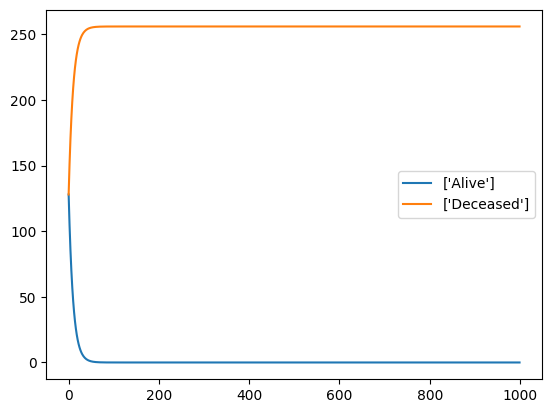

In [9]:
plot_by_labels([['Alive'], ['Deceased']])